In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import os, json
from skimage.segmentation import slic
from torchvision import transforms, models
import torch.nn.functional as F

import torch
import numpy as np

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

PIL.Image.Image

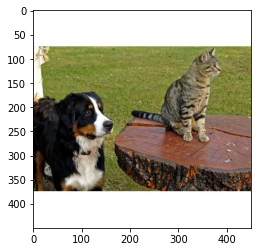

In [3]:
img = get_image('data/dogs.png')
plt.imshow(img)
type(img)

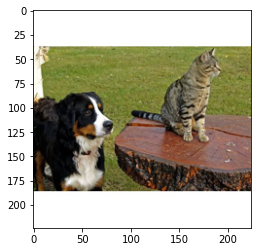

In [4]:
img.thumbnail((224,224))
plt.imshow(img)

In [5]:
to_tensor = transforms.ToTensor()
to_tensor(img).shape

torch.Size([3, 224, 224])

In [6]:
segments_slic = slic(img, n_segments=50, compactness=30, sigma=3)
segments_slic.shape

(224, 224)

In [78]:
img_orig = to_tensor(img)
#img_orig = torch.permute(img_orig, (2,1,0))
img_orig.shape



torch.Size([3, 224, 224])

In [8]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [9]:
model = models.vgg16(pretrained=True)

In [10]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./data/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}    

In [11]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

In [12]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.6444957, 239, 'Bernese_mountain_dog'),
 (0.20517309, 240, 'Appenzeller'),
 (0.05769792, 241, 'EntleBucher'),
 (0.05695658, 232, 'Border_collie'),
 (0.012026075, 238, 'Greater_Swiss_Mountain_dog'))

In [13]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [72]:
def batch_predict(images):
    model.eval()
    for i in images:
        print(preprocess_transform(i).shape)
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    print(batch.shape)
    print(batch)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [76]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.64

239

In [127]:
def batch_predict_t(images):
    print("==================inside batch_predict_t==================")
    model.eval()
    for i in images:
        print(i.shape)
    images = torch.from_numpy(images)
    images = [images]
    batch = torch.stack(tuple(i for i in images), dim=0)
    print(batch.shape)
    print(batch)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    print("==================outside batch_predict_t==================")
    return probs.detach().cpu().numpy()

In [129]:
test_pred_t = batch_predict_t(img_orig.numpy())

==================inside batch_predict_t==================
(224, 224)
(224, 224)
(224, 224)
torch.Size([1, 3, 224, 224])
tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])
==================outside batch_predict_t==================


In [130]:
import shap

In [132]:
explainer = shap.KernelExplainer(batch_predict_t, img_orig.numpy())
shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000) # runs VGG16 1000 times

==================inside batch_predict_t==================
(224, 224)
(224, 224)
(224, 224)
torch.Size([1, 3, 224, 224])
tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])
==================outside batch_predict_t==================


  0%|          | 0/1 [00:00<?, ?it/s]

IndexError: index 50 is out of bounds for axis 1 with size 50

In [116]:
img_orig.shape, img_orig.unsqueeze(dim=3).shape
img_orig_unsqueeze = img_orig.unsqueeze(dim=3)
img_orig_unsqueeze = torch.permute(img_orig_unsqueeze, (3,0,1,2))

In [118]:
test_pred_t.squeeze().argmax()


239

In [119]:
type(pill_transf(img)), type(preprocess_transform(img)), segments_slic.shape

(PIL.Image.Image, torch.Tensor, (224, 224))

In [120]:
test_pred = batch_predict([pill_transf(img)])

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.64

In [93]:
preprocess_transform(pill_transf(img)).shape

torch.Size([3, 224, 224])

(224, 224)

In [50]:
to_tensor(img).shape

torch.Size([3, 224, 224])

In [4]:
!pip install huggingface

In [6]:
!pip install transformers


     ━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/4.4 MB 185.3 kB/s eta 0:00:17
ERROR: Exception:
Traceback (most recent call last):
  File "/Users/cyrusmv/minicond/envs/torch/lib/python3.9/site-packages/pip/_vendor/urllib3/response.py", line 435, in _error_catcher
    yield
  File "/Users/cyrusmv/minicond/envs/torch/lib/python3.9/site-packages/pip/_vendor/urllib3/response.py", line 516, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "/Users/cyrusmv/minicond/envs/torch/lib/python3.9/site-packages/pip/_vendor/cachecontrol/filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
  File "/Users/cyrusmv/minicond/envs/torch/lib/python3.9/http/client.py", line 462, in read
    n = self.readinto(b)
  File "/Users/cyrusmv/minicond/envs/torch/lib/python3.9/http/client.py", line 506, in readinto
    n = self.fp.readinto(b)
  File "/Users/cyrusmv/minicond/envs/torch/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "/Users/cy

In [ ]:
impo